In [1]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

In [2]:
font = {'size': 16}
plt.rc('font', **font)

In [3]:
# ฟังก์ชันตรวจจับ Drip และบันทึกเดือน
def detect_drip_frequency(data, window=12, threshold=-0.05):
    drips = []
    for i in range(len(data) - window):
        if drips and (data.index[i] - drips[-1]['start_time']).total_seconds() / 3600 < window:
            continue  # ข้ามถ้า Drip ใหม่เริ่มภายใน 12 ชั่วโมงจาก Drip ก่อนหน้า
        
        close_price = data['close'].iloc[i]
        low_price = data['low'].iloc[i:i+window].min()
        drip_pct = (low_price - close_price) / close_price
        if drip_pct <= threshold:
            drips.append({
                'start_time': data.index[i],
                'month': data.index[i].month,
                'drip_pct': drip_pct * 100
            })
            # ข้าม 12 ชั่วโมงเพื่อลด Overlap
            i += window - 1
    return pd.DataFrame(drips)

In [4]:
data = pd.read_pickle(os.path.abspath("../../crypto/datasets/preprocessed/BTCUSDT/1h/features.pkl"))
#data = data["2024-01-01":"2024-12-31"]

# ตรวจจับ Drip และบันทึกจำนวนชั่วโมง
drips = detect_drip_frequency(data)

In [5]:
# 1. ความถี่ของ Drip ในแต่ละเดือน
drip_frequency = drips['month'].value_counts().sort_index().reset_index()
drip_frequency.columns = ['Month', 'Frequency']
drip_frequency['Percentage'] = (drip_frequency['Frequency'] / drip_frequency['Frequency'].sum() * 100).round(2)

print("\nDrip Frequency by Month:")
print(drip_frequency)


Drip Frequency by Month:
    Month  Frequency  Percentage
0       1         96       13.52
1       2         66        9.30
2       3         76       10.70
3       4         46        6.48
4       5         67        9.44
5       6         63        8.87
6       7         33        4.65
7       8         41        5.77
8       9         51        7.18
9      10         25        3.52
10     11         63        8.87
11     12         83       11.69


In [6]:
# สรุปสถิติความถี่
print("\nSummary of Drip Frequency:")
frequency_summary = {
    'Total Drips': len(drips),
    'Month with Max Drips': drip_frequency.loc[drip_frequency['Frequency'].idxmax(), 'Month'],
    'Max Frequency': drip_frequency['Frequency'].max(),
    'Month with Min Drips': drip_frequency.loc[drip_frequency['Frequency'].idxmin(), 'Month'],
    'Min Frequency': drip_frequency['Frequency'].min()
}
for key, value in frequency_summary.items():
    print(f"{key}: {value}")


Summary of Drip Frequency:
Total Drips: 710
Month with Max Drips: 1
Max Frequency: 96
Month with Min Drips: 10
Min Frequency: 25


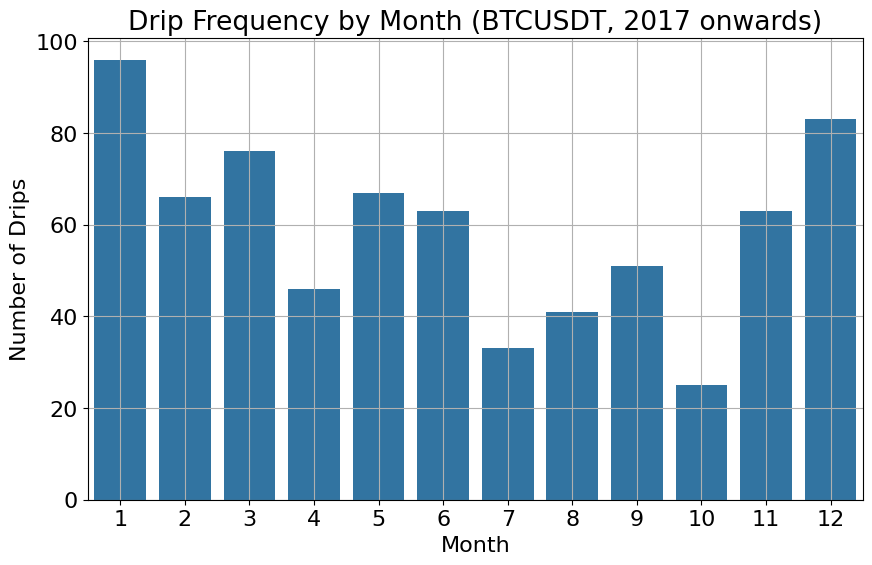

In [7]:
# สร้าง Bar Plot เพื่อแสดงความถี่
plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Frequency', data=drip_frequency)
plt.title('Drip Frequency by Month (BTCUSDT, 2017 onwards)')
plt.xlabel('Month')
plt.ylabel('Number of Drips')
plt.grid(True)
plt.show()

In [8]:
# 2. Chi-Square Test: ตรวจสอบการกระจายของความถี่ Drip ระหว่างเดือน
observed = drip_frequency['Frequency'].values
expected = np.full(len(observed), observed.sum() / 12)  # คาดหวังความถี่เท่ากันทุกเดือน
chi2_stat, p_value = stats.chisquare(observed, expected)
print(f"\nChi-Square Test for Drip Frequency: stat={chi2_stat:.4f}, p-value={p_value:.4f}")
if p_value < 0.05:
    print("Drip frequency differs significantly between months (p < 0.05)")
else:
    print("Drip frequency does not differ significantly between months (p >= 0.05)")


Chi-Square Test for Drip Frequency: stat=80.5803, p-value=0.0000
Drip frequency differs significantly between months (p < 0.05)


In [9]:
# 3. ความถี่ Drip จำแนกตามขนาด Drip
drips['drip_size_group'] = pd.cut(drips['drip_pct'], bins=[-float('inf'), -10, -5], labels=['Large (<-10%)', 'Small (-5% to -10%)'])
drip_size_frequency = drips.groupby(['month', 'drip_size_group']).size().unstack(fill_value=0).reset_index()
drip_size_frequency.columns = ['Month', 'Large (<-10%)', 'Small (-5% to -10%)']
print("\nDrip Frequency by Month and Size Group:")
print(drip_size_frequency)


Drip Frequency by Month and Size Group:
    Month  Large (<-10%)  Small (-5% to -10%)
0       1             13                   83
1       2              5                   61
2       3              2                   74
3       4              1                   45
4       5              6                   61
5       6              2                   61
6       7              0                   33
7       8              4                   37
8       9              7                   44
9      10              0                   25
10     11              5                   58
11     12             15                   68


/tmp/ipykernel_124077/167632315.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  drip_size_frequency = drips.groupby(['month', 'drip_size_group']).size().unstack(fill_value=0).reset_index()


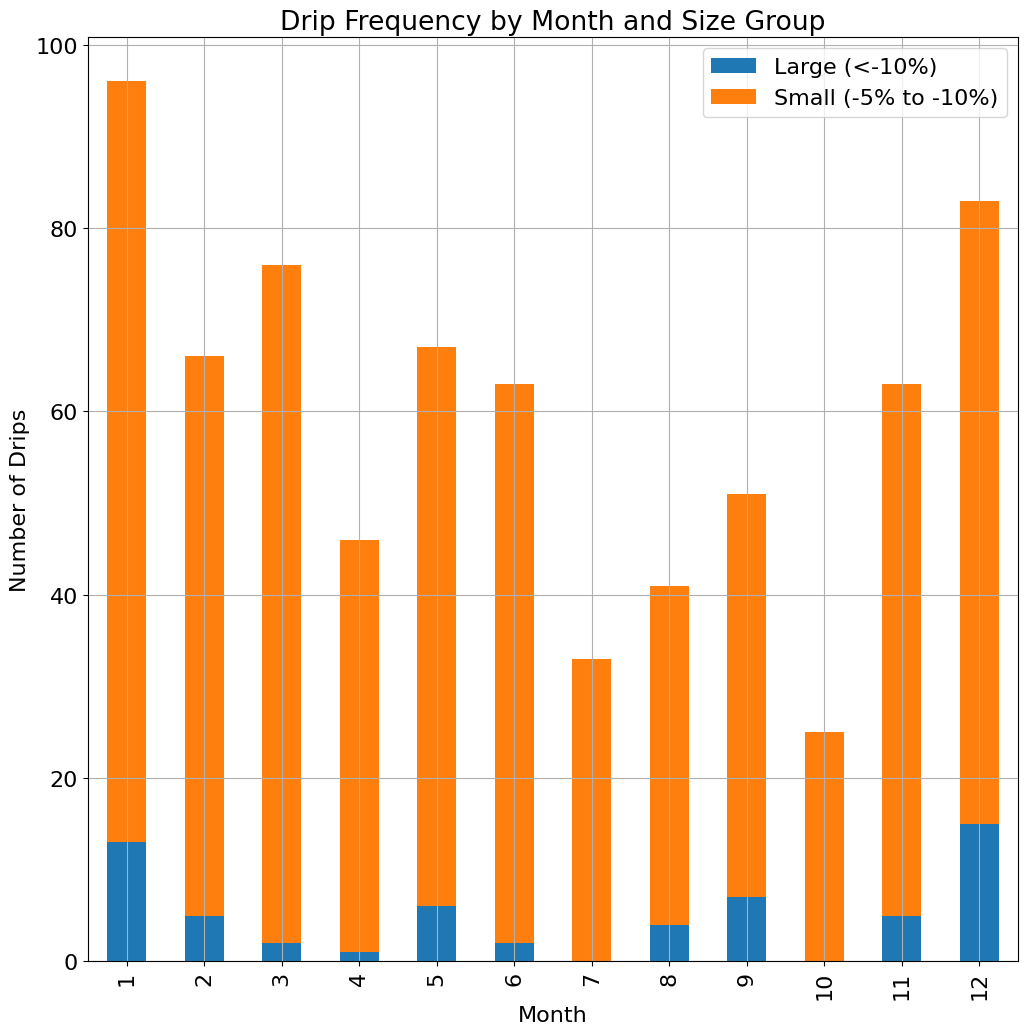

In [10]:
# สร้าง Stacked Bar Plot เพื่อแสดงความถี่ตามขนาด Drip
drip_size_frequency.set_index('Month').plot(kind='bar', stacked=True, figsize=(12, 12))
plt.title('Drip Frequency by Month and Size Group')
plt.xlabel('Month')
plt.ylabel('Number of Drips')
plt.grid(True)
plt.show()